<a href="https://colab.research.google.com/github/alexgastone/disaster_response_multilabel_classification/blob/master/models/DisasterResponse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilabel text classification - MODEL
using Deep Learning

# 1.0 Setup
## 1.1 Installations
Install `ktrain` for preprocessing the text data and training the model, and the `eli5` library for interpreting contributions of each word/expression in message to classification using LIME

In [0]:
!pip3 install ktrain

In [2]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

## 1.2 Import librairies

In [0]:
import pandas as pd
from sqlalchemy import create_engine
import os
import numpy as np

In [0]:
import ktrain
from ktrain import text

# 2.0 Get data
Load table from SQLite database with SQLAlchemy

In [269]:
database_filepath = 'DisasterResponse_split.db'

engine = create_engine('sqlite:///' + str(database_filepath))
table_name = database_filepath.split('.')[0]
table_name
df = pd.read_sql_table(table_name, engine)
df.head()

,id,split,message,original,genre,related,request,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,uncategorized
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [5]:
engine = create_engine('sqlite:///DisasterResponse_split.db')
df = pd.read_sql_table('DisasterResponse_split', engine)
df.head()

,id,split,message,original,genre,related,request,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,uncategorized
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [137]:
df['related'].max()

2

In [0]:
df['related'] = df['related'].apply(lambda x: 1 if x>0 else 0)

In [139]:
df['related'].max()

1

In [5]:
# number of rows with no True label
(df.iloc[:,4::].sum(axis=1) == 0).sum()

0

In [4]:
# number of rows with at least 1 True label
(df.iloc[:,4::].sum(axis=1) > 0).sum()

26216

In [0]:
df.drop(['child_alone'], axis=1, inplace=True)

In [7]:
print(f"Number of samples in data: {df.shape[0]}")

Number of samples in data: 26216


In [0]:
#target_categories = df.columns.tolist()[4:]
target_categories = df.columns.tolist()[5:]

In [7]:
len(target_categories)

35

# BERT
using `transformers` from HuggingFace and pytorch

In [0]:
!pip install transformers

## 1.0 Tokenizer

In [0]:
from transformers import BertTokenizer

bert_model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)
MAX_LEN = 128

In [0]:
from tqdm.notebook import tqdm

In [0]:
def tokenize_sentences(sentences, tokenizer, max_seq_len = 128):
    tokenized_sentences = []
    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)
    return tokenized_sentences

In [0]:
def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []
    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)
    return np.asarray(attention_masks)

In [13]:
from keras.preprocessing.sequence import pad_sequences

input_ids = tokenize_sentences(df['message'], tokenizer, MAX_LEN)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
attention_masks = create_attention_masks(input_ids)

Using TensorFlow backend.


In [0]:
label_cols = df.columns.tolist()[4:]
labels = df[label_cols].values 

## 2.0 Preprocess datasets

In [0]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=0, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=0, test_size=0.1)

In [16]:
train_size = len(train_inputs)
validation_size = len(validation_inputs)

print(f"number of samples in training: {train_size}, number of samples in validation: {validation_size}")
print(f"number of labels in training: {train_labels.shape[1]}, number of labels in validation: {validation_labels.shape[1]}")

number of samples in training: 23594, number of samples in validation: 2622
number of labels in training: 36, number of labels in validation: 36


In [0]:
def create_dataset(data_tuple, epochs=1, batch_size=32, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)
    
    return dataset

In [0]:
import tensorflow as tf

In [0]:
BATCH_SIZE = 32
NR_EPOCHS = 2

train_dataset = create_dataset((train_inputs, train_masks, train_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
validation_dataset = create_dataset((validation_inputs, validation_masks, validation_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)

## 3.0 Create model

In [23]:
print(f'number of classes: {len(label_cols)}')

number of classes: 35


In [0]:
from transformers import TFBertModel
from tensorflow.keras.layers import Dense, Flatten

# add a dense layer to BERT outputs with sigmoid activation function
class BertClassifier(tf.keras.Model):    
    def __init__(self, bert: TFBertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = Dense(num_classes, activation='sigmoid')
        
    @tf.function
    def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)
        cls_output = outputs[1]
        cls_output = self.classifier(cls_output)
                
        return cls_output

model = BertClassifier(TFBertModel.from_pretrained(bert_model_name), len(label_cols))

In [0]:
import time
from transformers import create_optimizer

In [0]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = validation_size // BATCH_SIZE

In [55]:
steps_per_epoch, validation_steps

(737, 81)

In [0]:
# loss: binary cross entropy with logits
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
train_loss = tf.keras.metrics.Mean(name='train_loss')
validation_loss = tf.keras.metrics.Mean(name='test_loss')

In [0]:
# Optimizer (with 1-cycle-policy)
warmup_steps = steps_per_epoch // 3
#total_steps = steps_per_epoch * NR_EPOCHS - warmup_steps
total_steps = steps_per_epoch - warmup_steps
optimizer = create_optimizer(init_lr=3e-5, num_train_steps=total_steps, num_warmup_steps=warmup_steps)

In [0]:
# Metrics
train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]
validation_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]

In [0]:
@tf.function
def train_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(token_ids, attention_mask=masks)
        loss = loss_object(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables), 1.0)

    train_loss(loss)

    for i, auc in enumerate(train_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])

In [0]:
@tf.function
def validation_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    predictions = model(token_ids, attention_mask=masks, training=False)
    v_loss = loss_object(labels, predictions)

    validation_loss(v_loss)
    for i, auc in enumerate(validation_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])

In [0]:
def train(model, train_dataset, val_dataset, train_steps_per_epoch, val_steps_per_epoch, epochs):
    for epoch in range(epochs):
        print(f"EPOCH {epoch+1}/{epochs}")

        for i, (token_ids, masks, labels) in enumerate(tqdm(train_dataset, total=train_steps_per_epoch)):
            train_step(model, token_ids, masks, labels)
            if i % 200 == 0:
                print(f'\nTrain Step: {i}, Loss: {train_loss.result()}')
                for i, label_name in enumerate(label_cols):
                    print(f"{label_name} ROC-AUC {train_auc_metrics[i].result()}")
                    train_auc_metrics[i].reset_states()
        
        for i, (token_ids, masks, labels) in enumerate(tqdm(val_dataset, total=val_steps_per_epoch)):
            validation_step(model, token_ids, masks, labels)

        print(f'\nValidation Loss: {validation_loss.result()} \n')

        val_auc_avg = 0
        for i, label_name in enumerate(label_cols):
            print(f"{label_name} ROC-AUC {validation_auc_metrics[i].result()}")
            val_auc_avg += validation_auc_metrics[i].result()
            validation_auc_metrics[i].reset_states()
        val_auc_avg = val_auc_avg / len(label_cols)
        print(f'\n Average AUC-ROC score on validation set: {val_auc_avg}')
        print('\n')

In [30]:
# make sure you run with GPU, takes ~20min for training per epoch
with tf.device('/device:GPU:0'):
  train(model, train_dataset, validation_dataset, train_steps_per_epoch=steps_per_epoch, val_steps_per_epoch=validation_steps, epochs=NR_EPOCHS)

EPOCH 1/2



Train Step: 0, Loss: 0.9319369196891785
related ROC-AUC 0.0962962955236435
request ROC-AUC 0.2916666567325592
offer ROC-AUC 0.0
aid_related ROC-AUC 0.6215686202049255
medical_help ROC-AUC 0.4583333134651184
medical_products ROC-AUC 0.4464285671710968
search_and_rescue ROC-AUC 0.6612903475761414
security ROC-AUC 0.9193548560142517
military ROC-AUC 0.6916666626930237
water ROC-AUC 0.40740740299224854
food ROC-AUC 0.5
shelter ROC-AUC 0.227678582072258
clothing ROC-AUC 0.0
money ROC-AUC 0.0
missing_people ROC-AUC 0.0
refugees ROC-AUC 0.4749999940395355
death ROC-AUC 0.629464328289032
other_aid ROC-AUC 0.5259259343147278
infrastructure_related ROC-AUC 0.24193549156188965
transport ROC-AUC 0.0
buildings ROC-AUC 0.19999998807907104
electricity ROC-AUC 0.33870968222618103
tools ROC-AUC 0.0
hospitals ROC-AUC 0.0
shops ROC-AUC 0.0
aid_centers ROC-AUC 0.3870967924594879
other_infrastructure ROC-AUC 0.0
weather_related ROC-AUC 0.6822916865348816
floods ROC-AUC 0.5862069129943848
storm ROC-AUC 0.8



Validation Loss: 0.6929114460945129 

related ROC-AUC 0.7623892426490784
request ROC-AUC 0.5374180674552917
offer ROC-AUC 0.5
aid_related ROC-AUC 0.6925266981124878
medical_help ROC-AUC 0.4997929632663727
medical_products ROC-AUC 0.5275626182556152
search_and_rescue ROC-AUC 0.4998040795326233
security ROC-AUC 0.5017509460449219
military ROC-AUC 0.4998031556606293
water ROC-AUC 0.6039391756057739
food ROC-AUC 0.4957500994205475
shelter ROC-AUC 0.4997904300689697
clothing ROC-AUC 0.49458831548690796
money ROC-AUC 0.5
missing_people ROC-AUC 0.4998064339160919
refugees ROC-AUC 0.43944838643074036
death ROC-AUC 0.5662482976913452
other_aid ROC-AUC 0.49978020787239075
infrastructure_related ROC-AUC 0.49959349632263184
transport ROC-AUC 0.5
buildings ROC-AUC 0.3246167302131653
electricity ROC-AUC 0.3916708827018738
tools ROC-AUC 0.4996161162853241
hospitals ROC-AUC 0.4998074769973755
shops ROC-AUC 0.5
aid_centers ROC-AUC 0.4972972869873047
other_infrastructure ROC-AUC 0.5375728011131287
wea


Train Step: 0, Loss: 0.7059513926506042
related ROC-AUC 0.7847247123718262
request ROC-AUC 0.5383827090263367
offer ROC-AUC 0.49978965520858765
aid_related ROC-AUC 0.7004571557044983
medical_help ROC-AUC 0.4995427429676056
medical_products ROC-AUC 0.5315104722976685
search_and_rescue ROC-AUC 0.4997842013835907
security ROC-AUC 0.5002124905586243
military ROC-AUC 0.499566912651062
water ROC-AUC 0.586609959602356
food ROC-AUC 0.4971415102481842
shelter ROC-AUC 0.5002316236495972
clothing ROC-AUC 0.4968017041683197
money ROC-AUC 0.4997852146625519
missing_people ROC-AUC 0.4995768070220947
refugees ROC-AUC 0.42647844552993774
death ROC-AUC 0.5798134207725525
other_aid ROC-AUC 0.4995131492614746
infrastructure_related ROC-AUC 0.49933600425720215
transport ROC-AUC 0.4997801184654236
buildings ROC-AUC 0.3071994185447693
electricity ROC-AUC 0.47426849603652954
tools ROC-AUC 0.499789297580719
hospitals ROC-AUC 0.49957752227783203
shops ROC-AUC 0.49978938698768616
aid_centers ROC-AUC 0.49704018

KeyboardInterrupt: ignored

In [0]:
model

In [0]:
MODEL_PATH = './trained_model.pth'
torch.save(model.state_dict(), PATH)

## 2.1 Preprocess text
Label columns are already one hot encoded in the dataframe.

In [0]:
!pip install ktrain

In [0]:
from ktrain import text

In [9]:
df.tail(2)

,id,split,message,original,genre,related,request,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,uncategorized
23596,30248,validation,WHO is recruiting a sanitary engineer / consul...,None,news,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
23597,30258,validation,However while ECOWAS wanted him to lead a 12-m...,None,news,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [226]:
NUM_WORDS = 50000
MAXLEN = 128

# uses 10% of data to split for training/validation if val not specified
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df[df['split']=='train'],      # training
                                                                   'message',                     # text col                                            
                                                                   target_categories,             # label col
                                                                   df[df['split']=='validation'], # validation
                                                                   max_features=NUM_WORDS,        # max features
                                                                   maxlen=MAXLEN,                 # max len
                                                                   ngram_range=1,                 # n_gram 
                                                                   preprocess_mode='bert')        # model

# if running BERT, add argument preprocess_mode='bert' (default is 'standard')

preprocessing train...
language: en


preprocessing test...
language: en


In [227]:
(y_test.sum(axis=1) == 0).sum()

0

# 3.0 Train the model

## 3.1 Instantiate the model
We'll define our model with Bidirection Gated Recurrent Circuit (`bigru`) architecture using ktrain. Bidirectional GRUs are a type of RNN with only input and forget gates. Pretrained word vectors are loaded from file containing 2million word vectors trained by Facebook.

In [228]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc, multilabel=True)

Is Multi-Label? True
maxlen is 128
done.


In [0]:
# wrap model and data in learner object
learner = ktrain.get_learner(model, train_data=(x_train, y_train),
                             val_data=(x_test, y_test))

## 3.2 Estimate a good learning rate

simulating training for different learning rates... this may take a few moments...
Train on 21027 samples
Epoch 1/2
21027/21027 [==============================] - 1128s 54ms/sample - loss: 0.3867 - accuracy: 0.8093
Epoch 2/2
 8384/21027 [==========>...................] - ETA: 11:04 - loss: 0.3842 - accuracy: 0.9054

done.
Visually inspect loss plot and select learning rate associated with falling loss


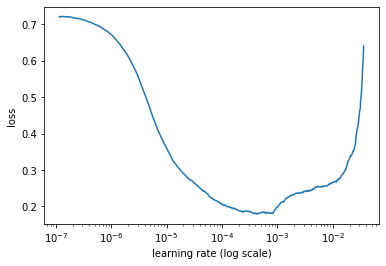

In [15]:
# estimate learning rate
learner.lr_find(show_plot=True, max_epochs=2)

In [0]:
LEARN_RATE = 0.00001 #1e-5

## 3.3 Training

In [0]:
# from https://github.com/amaiya/ktrain/blob/master/examples/text/toxic_comments-bigru.ipynb
# define a custom callback for ROC-AUC
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
class RocAucEvaluation(Callback):
  def __init__(self, validation_data=(), interval=1):
    super(Callback, self).__init__()

    self.interval = interval
    self.X_val, self.y_val = validation_data

  def on_epoch_end(self, epoch, logs={}):
    # evaluate at the end of epoch
    if epoch % self.interval == 0:
      y_pred = self.model.predict(self.X_val, verbose=0)
      score = roc_auc_score(self.y_val, y_pred)
      print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

RocAuc = RocAucEvaluation(validation_data=(x_test, y_test), interval=1)

In [0]:
import tensorflow as tf

In [230]:
# run training using triangular learning rate scheduler
NUM_EPOCHS = 2

# make sure no null label (i.e. all labels are False) samples if using callback
# and predictions are binary
with_callback = True

with tf.device('/device:GPU:0'):
  if with_callback:
    learner.autofit(LEARN_RATE, NUM_EPOCHS, callbacks=[RocAuc])
  else:
    learner.autofit(LEARN_RATE, NUM_EPOCHS)



begin training using triangular learning rate policy with max lr of 1e-05...
Train on 21027 samples, validate on 2571 samples
Epoch 1/2
21024/21027 [============================>.] - ETA: 0s - loss: 0.2929 - accuracy: 0.8918
 ROC-AUC - epoch: 1 - score: 0.772915 

21027/21027 [==============================] - 1206s 57ms/sample - loss: 0.2929 - accuracy: 0.8918 - val_loss: 0.1829 - val_accuracy: 0.9398
Epoch 2/2
21024/21027 [============================>.] - ETA: 0s - loss: 0.1725 - accuracy: 0.9423
 ROC-AUC - epoch: 2 - score: 0.838157 

21027/21027 [==============================] - 1177s 56ms/sample - loss: 0.1726 - accuracy: 0.9423 - val_loss: 0.1601 - val_accuracy: 0.9457


## 3.4 Tuning

Using split dataset:
* training: 0.9423
* validation: 0.9457
* ROC-AUC: 0.8382

Dropping only `child_alone` and running with BERT (instead if bigru):
* training: 0.9621
* validation: 0.9533
* ROC-AUC: ~0.90

Dropping `related` and `child_alone`, accuracy:
* training: 0.9246
* validation: 0.9246
* ROC-AUC: dropping `related` created rows with no True labels, can't run ROC-AUC

Adding `unclassified` col and increasing `max_len` to 336, accuracy:
* training: **0.9222**
* validation: **0.9220**
* ROC-AUC: **0.9017**

2 epochs is enough.

Accuracy:
* training: **0.9263**
* validation: **0.9285**
* ROC-AUC: can't run ROC-AUC if some samples contain no True labels


## 3.4 Evaluate ROC-AUC score on validation data

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

In [231]:
y_pred = model.predict(x_test, verbose=1)

2571/2571 [==============================] - 39s 15ms/sample


In [0]:
plt.style.use('dark_background')

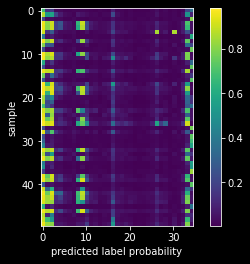

In [232]:
plt.imshow(y_pred[0:50])
plt.colorbar()
plt.ylabel('sample')
plt.xlabel('predicted label probability');

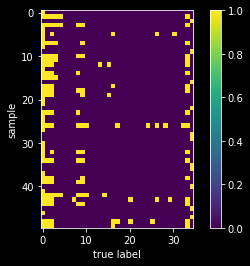

In [233]:
plt.imshow(y_test[0:50])
plt.colorbar()
plt.ylabel('sample')
plt.xlabel('true label');

In [58]:
# no samples can be "unlabelled" in order for ROC-AUC to work
(y_test.sum(axis=1) == 0).sum()

0

In [235]:
from sklearn.metrics import roc_auc_score

y_pred_thresh = (y_pred>0.3)
avg_score = 0
for idx, row in enumerate(y_pred_thresh):
  try:
    score = roc_auc_score(y_test[idx], row, average='macro', multi_class='ovo', labels=target_categories)
    avg_score += score
  except:
    print(idx, row)
avg_score = avg_score / y_pred.shape[0]
print(f'Average ROC-AUC score if set threshold to 0.3 is {avg_score}')

Average ROC-AUC score if set threshold to 0.3 is 0.8680170212292859


In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss

thresh = np.linspace(0.1, 0.5, num=50)
avg_score_auc_list = []
avg_score_accuracy_list = []
avg_score_f1_list = []
avg_score_hl_list = []

for t in thresh:
  y_pred_thresh = (y_pred>t)
  avg_score_auc, avg_score_a, avg_score_f1, avg_score_hl = 0, 0, 0, 0

  for idx, row in enumerate(y_pred_thresh):
    try:
      # weighted: calculate metrics for each label, and find their weighted mean, takes label imbalance into account
      score_auc = roc_auc_score(y_test[idx], row, average='weighted')
      avg_score_auc += score_auc

      score_a = accuracy_score(y_test[idx], row)
      avg_score_a += score_a

      score_f1 = f1_score(y_test[idx], row, average='weighted')
      avg_score_f1 += score_f1

      score_hl = hamming_loss(y_test[idx], row)
      avg_score_hl += score_hl
    except:
      print(idx, row)

  avg_score_auc_list.append(avg_score_auc / y_pred.shape[0])
  avg_score_accuracy_list.append(avg_score_a / y_pred.shape[0])
  avg_score_f1_list.append(avg_score_f1 / y_pred.shape[0])
  avg_score_hl_list.append(avg_score_hl / y_pred.shape[0])

In [0]:
ind_list = (np.linspace(0,len(thresh)-1, num=6, dtype='int')).tolist()

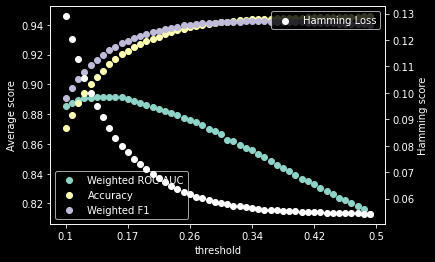

In [238]:
fig, ax = plt.subplots()
ax.scatter(np.arange(len(thresh)), avg_score_auc_list, label='Weighted ROC-AUC')
ax.scatter(np.arange(len(thresh)), avg_score_accuracy_list, label='Accuracy')
ax.scatter(np.arange(len(thresh)), avg_score_f1_list, label='Weighted F1')
ax2 = ax.twinx()
ax2.scatter(np.arange(len(thresh)), avg_score_hl_list, label='Hamming Loss', color='white')
#plt.xticks(np.arange(0,len(thresh),10), np.round(thresh[ind_list],2))
ax.set_xticklabels(np.hstack([0, np.round(thresh[ind_list],2)]))
ax.legend()
ax2.legend()
ax.set_xlabel('threshold')
ax.set_ylabel('Average score')
ax2.set_ylabel('Hamming score');

In [149]:
print(f'Max ROC-AUC score at a threshold of {thresh[avg_score_auc_list.index(max(avg_score_auc_list))]}')

Max ROC-AUC score at a threshold of 0.14081632653061227


In [0]:
best_thresh_auc = thresh[avg_score_auc_list.index(max(avg_score_auc_list))]

In [257]:
print(f'Accuracy: {avg_score_auc_list[avg_score_auc_list.index(max(avg_score_auc_list))]} \
      \nF1 score: {avg_score_f1_list[avg_score_auc_list.index(max(avg_score_auc_list))]} \
      \nAUC-SCORE: {avg_score_auc_list[avg_score_auc_list.index(max(avg_score_auc_list))]} \
      \nHamming loss: {avg_score_hl_list[avg_score_auc_list.index(max(avg_score_auc_list))]}')

Accuracy: 0.8918457879041098       
F1 score: 0.9228728374073598       
AUC-SCORE: 0.8918457879041098       
Hamming loss: 0.08656998388620506


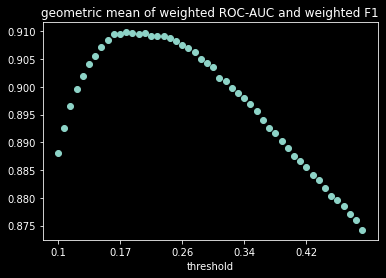

In [261]:
from scipy.stats.mstats import gmean
gmean_ = [gmean([a,b]) for a,b in zip(avg_score_f1_list, avg_score_auc_list)]
plt.title('geometric mean of weighted ROC-AUC and weighted F1')
plt.scatter(np.arange(len(thresh)), gmean_)
plt.xticks(np.arange(0,len(thresh),10), np.round(thresh[ind_list],2))
plt.xlabel('threshold');

In [263]:
best_thresh_mean = thresh[gmean_.index(max(gmean_))]
print(f'Max score at a threshold of {best_thresh_mean}')

Max score at a threshold of 0.18979591836734694


In [264]:
print(f'Accuracy: {avg_score_auc_list[gmean_.index(max(gmean_))]} \
      \nF1 score: {avg_score_f1_list[gmean_.index(max(gmean_))]} \
      \nAUC-SCORE: {avg_score_auc_list[gmean_.index(max(gmean_))]} \
      \nHamming loss: {avg_score_hl_list[gmean_.index(max(gmean_))]}')

Accuracy: 0.8889179157007003       
F1 score: 0.9312149181776512       
AUC-SCORE: 0.8889179157007003       
Hamming loss: 0.0749902761571391


In [0]:
best_thresh = np.round(best_thresh_mean, 2)

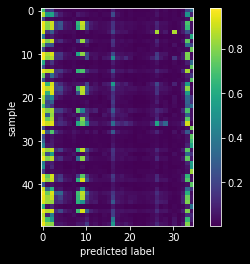

In [242]:
fig, ax= plt.subplots()
img = ax.imshow(y_pred[0:50])
fig.colorbar(img)
ax.set_ylabel('sample')
ax.set_xlabel('predicted label');

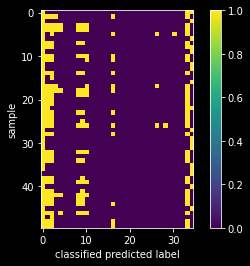

In [267]:
fig, ax= plt.subplots()
img = ax.imshow(y_pred[0:50]>best_thresh)
fig.colorbar(img)
ax.set_ylabel('sample')
ax.set_xlabel('classified predicted label');

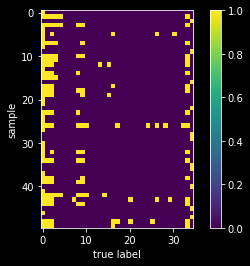

In [244]:
# true label
fig, ax= plt.subplots()
img = ax.imshow(y_test[0:50])
fig.colorbar(img)
ax.set_ylabel('sample')
ax.set_xlabel('true label');


In [0]:
from sklearn.metrics import roc_auc_score

avg_score = 0
for idx, row in enumerate(y_pred):
  try:
    score = roc_auc_score(y_test[idx], row, average='macro', multi_class='ovo', labels=target_categories)
    avg_score += score
  except:
    print(idx, row)

avg_score = avg_score / y_pred.shape[0]
print(f'Average ROC-AUC score is {avg_score}')

# 4.0 Check interpretability for a validation example

In [0]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [169]:
y_pred_test = predictor.predict(["We are more than 50 people on the street. Please help us find tent, food"])

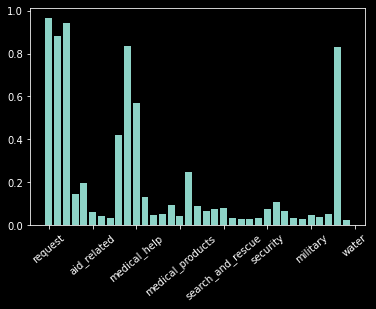

In [173]:
category = []
probability = []

for item in y_pred_test[0]:
  category.append(item[0])
  probability.append(item[1])

fig, ax = plt.subplots()
ax.bar(np.arange(len(category)), probability)
ax.set_xticklabels(category, rotation=40);

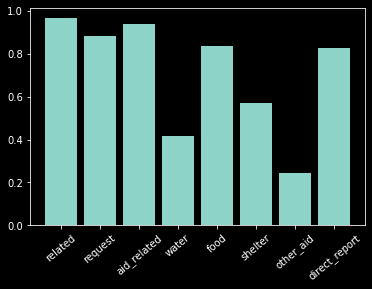

In [178]:
# by just looking at the labels with predictions > 0.2

category = []
probability = []

for item in y_pred_test[0]:
  if item[1]>0.2:
    category.append(item[0])
    probability.append(item[1])

fig, ax = plt.subplots()
ax.bar(np.arange(len(category)), probability)
ax.set_xticklabels(np.hstack(['0', category]), rotation=40);

In [194]:
y_pred_test[0][0]

('related', 0.9653509)

In [179]:
proba = predictor.predict_proba(["We are more than 50 people on the street. Please help us find tent, food"])
proba

array([[0.9653509 , 0.8818212 , 0.94036984, 0.146092  , 0.19550593,
        0.06301989, 0.04434655, 0.03172754, 0.41869023, 0.83398324,
        0.56947577, 0.13086635, 0.04902482, 0.0504084 , 0.09431522,
        0.04250012, 0.24644381, 0.08745599, 0.06539655, 0.07432987,
        0.08099597, 0.03165624, 0.02731479, 0.0305072 , 0.03498624,
        0.07710399, 0.10933775, 0.06739019, 0.03280334, 0.02782248,
        0.04662247, 0.03777857, 0.05025714, 0.82884526, 0.02279187]],
      dtype=float32)

In [0]:
classification_results = {target_category : prob for target_category, prob in zip(target_categories, proba[0])}

In [222]:
for category, classification in classification_results.items():
  if classification > 0.2:
    print(category)

related
request
aid_related
water
food
shelter
other_aid
direct_report


In [0]:
import eli5
from eli5.lime import TextExplainer

test_doc = "We are more than 50 people on the street. Please help us find tent, food"

te = TextExplainer(random_state=32)
te.fit(test_doc, predictor.predict_proba)

te.show_prediction(target_names=target_categories)

# 5.0 Predict on new data

In [0]:
# Instantiate predictor object
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [0]:
# save as JSON file
model_json = learner.model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

In [0]:
learner.model.save_weights('model.h5')

In [0]:
# can load from saved model and preproc
import h5py    
import pickle
 
model = h5py.File("/content/bert_finetuned_model",'r+')
preproc = pickle.load(open("/content/bert_finetuned_model.preproc","rb"))

In [0]:
#predictor = ktrain.get_predictor(learner.model, preproc)
#predictor.save('/content/bert_finetuned_model')

loaded_model = ktrain.load_predictor('bert_finetuned_model')

In [0]:
y_pred = predictor.predict(["We are more than 50 people on the street. Please help us find tent, food"])

# predicted probability scores for each category (neg, neutral, pos)
y_pred_prob = predictor.predict_proba(['We are more than 50 people on the street. Please help us find tent, food'])

In [0]:
from matplotlib import pyplot as plt
import numpy as np

In [0]:
%matplotlib inline

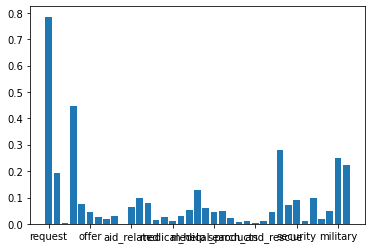

In [34]:
category = []
probability = []

for item in y_pred[0]:
  category.append(item[0])
  probability.append(item[1])

fig, ax = plt.subplots()
ax.bar(np.arange(len(category)), probability)
ax.set_xticklabels(category);

# 5.0 Save predictor object

In [0]:
# saved as h5 file
predictor.save('/content/bert_finetuned_model')